<a href="https://colab.research.google.com/github/olesyamba/python_compilation/blob/main/clusterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Мини-таска**
1. Проверить на дубликаты

2. отфильтровать наблюдения: оставляем только те наблюдения, которые не дубликаты, у которых noncondition=0 и где плотность газа (dens_gas)<1

3. Убрать выбросы по температуре

4. Кластеризация: используем 9 признаков (столбцов), начиная с Рпл
предварительно стандартизируем эти показатели
кластеризация на 3 кластера

5. Рассчитать кол-во записей в каждом кластере и кол-во плстов, попавших в каждый кластер

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
# pio.renderers.default = "browser"
# pio.renderers
# Set the Plotly renderer to 'colab'
pio.renderers.default = 'colab'
import datetime
from xlrd.xldate import xldate_as_datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Step 1: Check for duplicates
def check_duplicates(df):
    duplicates = df.duplicated()
    return df[~duplicates], duplicates

# Step 2: Filter observations
def filter_observations(df):
    filtered_df = df[(df['noncondition'] == 0) & (df['dens_gas'] < 1)]
    removed_df = df[~(df['noncondition'] == 0) | ~(df['dens_gas'] < 1)]
    return filtered_df, removed_df

# Step 3: Remove outliers by temperature
def remove_temperature_outliers(df):
    # Assuming temperature column is named 'temperature'
    Q1 = df['Temperature'].quantile(0.25)
    Q3 = df['Temperature'].quantile(0.75)
    IQR = Q3 - Q1
    filtered_df = df[~((df['Temperature'] < (Q1 - 1.5 * IQR)) | (df['Temperature'] > (Q3 + 1.5 * IQR)))]
    outliers = df[((df['Temperature'] < (Q1 - 1.5 * IQR)) | (df['Temperature'] > (Q3 + 1.5 * IQR)))]
    return filtered_df, outliers

# Step 4: PCA
def apply_pca(df):
    attributes = df.loc[:, 'Pbl':] # Assuming columns Pbl to the end are the attributes
    scaler = StandardScaler()
    scaled_attributes = scaler.fit_transform(attributes)

    pca = PCA(n_components=2)  # You can choose the number of components
    pca_result = pca.fit_transform(scaled_attributes)

    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

    return pca_df

# Step 4: PCA
def apply_pca2(df):
    attributes = df.loc[:, 'Pbl':] # Assuming columns Pbl to the end are the attributes
    scaler = StandardScaler()
    scaled_attributes = scaler.fit_transform(attributes)

    pca = PCA()  # No need to specify n_components here
    pca_result = pca.fit_transform(scaled_attributes)

    pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

    # Plot cumulative explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             np.cumsum(pca.explained_variance_ratio_),
             marker='o', linestyle='-')
    plt.title('Cumulative Explained Variance Ratio')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    return pca_df

# Step 5: Visualization of PCA
def visualize_pca(pca_df):
    sns.scatterplot(x='PC1', y='PC2', data=pca_df)
    plt.title('PCA Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Step 4: PCA with 3 components
def apply_pca3(df):
    attributes = df.loc[:, 'Pbl':] # Assuming columns Pbl to the end are the attributes
    scaler = StandardScaler()
    scaled_attributes = scaler.fit_transform(attributes)

    pca = PCA(n_components=3)  # Now using 3 components
    pca_result = pca.fit_transform(scaled_attributes)

    pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

    return pca_df

# Step 6: Clustering
def clustering(df):
    kmeans = KMeans(n_clusters=3, random_state=0)
    df['cluster'] = kmeans.fit_predict(df)

    cluster_counts = df['cluster'].value_counts()
    plast_counts = df.groupby('cluster')['layer'].nunique()

    return cluster_counts, plast_counts

# Step 6: Clustering
def clustering_pca(df):
    kmeans = KMeans(n_clusters=3, random_state=0)
    df['cluster'] = kmeans.fit_predict(df)

    cluster_counts = df['cluster'].value_counts()
    return cluster_counts

# Step 7: Visualization of clustering decomposed on before PCA variables
def visualize_clustering_decomposed(df, original_df):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    sns.jointplot(x='Pbl', y='K_Vol_elasticity', hue='cluster', data=original_df, palette='viridis', ax=axs[0])
    # sns.scatterplot(x='Pbl', y='dens_gas', hue='cluster', data=original_df, palette='viridis', ax=axs[0])
    axs[0].set_title('Clustering on Original Variables')
    axs[0].set_xlabel('Pbl')
    axs[0].set_ylabel('K_Vol_elasticity')

    g = sns.PairGrid(df, diag_sharey=False,  hue='cluster', palette='viridis')
    g.map_upper(sns.scatterplot)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot)
    g.add_legend()

    sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df, palette='viridis', ax=axs[1]) #
    axs[1].set_title('Clustering on PCA Components')
    axs[1].set_xlabel('Principal Component 1')
    axs[1].set_ylabel('Principal Component 2')

    plt.show()

# Step 8: Visualization of temperature outliers
def visualize_temperature_outliers(df, outliers):
    fig, ax = plt.subplots()

    sns.boxplot(x='Temperature', data=df, ax=ax)
    sns.swarmplot(x='Temperature', data=outliers, color='red', ax=ax)

    plt.title('Temperature Boxplot with Outliers Highlighted')
    plt.xlabel('Temperature')
    plt.show()

# Step 7: 3D Scatterplot for PCA results
def visualize_pca_3d(pca_df):
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

    fig.add_trace(go.Scatter3d(x=pca_df['PC1'], y=pca_df['PC2'], z=pca_df['PC3']), row=1, col=1)

    fig.update_layout(title='Interactive PCA 3D Visualization',
                      scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'),
                      showlegend=True)

    fig.show()

# Step 7: Interactive 3D Scatterplot for PCA results
def visualize_pca_cluster_3d(pca_df):
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

    for cluster in pca_df['cluster'].unique():
        cluster_data = pca_df[pca_df['cluster'] == cluster]
        fig.add_trace(go.Scatter3d(x=cluster_data['PC1'], y=cluster_data['PC2'], z=cluster_data['PC3'],
                                    mode='markers', marker=dict(size=5),
                                    name=f'Cluster {cluster}'), row=1, col=1)

    fig.update_layout(title='Interactive PCA 3D Visualization',
                      scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'),
                      showlegend=True)

    fig.show()


In [ ]:
path = '/content/Для кластеризации.xlsx'

In [ ]:
df = pd.read_excel(f'{path}',
                  header=3,
                  # usecols='A, AB',
                  # converters={
                  # 'date': lambda x: xldate_as_datetime(float(x), 0)
                  # }
                  )

In [ ]:
df.head()

,Well,Int_perf,layer,date,depth,Pres,Temperature,Pbl,K_Vol_elasticity,T_сoef_Pbl,...,density_sep_oil,density_oil_Pres,density_oil_Pbl,visc_oil_Pres,visc_sep_oil_Tres,visc_sep_oil_20C,dens_gas,noncondition,ratio_density_stand-step,Unnamed: 23
0,1PO,2263-2285,AC9,2018-03-21 00:00:00,1900,22.0,76.0,9.28,9.30,0.0415,...,870.0,836.6,826.0,1.56,3.682,16.42,0.859,0,1.004039,NaN
1,1PO,2263-2285,AC9,2018-03-21 00:00:00,1900,22.0,76.0,9.33,8.95,0.0426,...,870.0,836.6,826.0,1.56,3.682,16.42,0.859,0,NaN,NaN
2,1PO,2263-2285,AC9,2018-03-21 00:00:00,1900,22.0,76.0,10.02,9.29,0.0471,...,872.8,836.5,831.5,1.41,3.964,17.73,0.852,0,NaN,NaN
3,1PO,2263-2285,AC9,2018-03-18 00:00:00,2220,23.0,78.0,16.11,11.88,0.0719,...,874.2,828.3,821.4,1.33,4.380,22.63,0.817,1,1.002408,NaN
4,1PO,2263-2285,AC9,2018-03-18 00:00:00,2220,23.0,78.0,15.48,10.70,0.0690,...,874.3,828.8,822.1,1.39,4.510,22.67,0.812,1,NaN,NaN


In [ ]:
df.describe()

,Pres,Temperature,Pbl,K_Vol_elasticity,T_сoef_Pbl,T_coef_vol_expansion,Gas_content,V_coef_Pres,V_coef_Pbl,density_sep_oil,density_oil_Pres,density_oil_Pbl,visc_oil_Pres,visc_sep_oil_Tres,visc_sep_oil_20C,dens_gas,noncondition,ratio_density_stand-step,Unnamed: 23
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,24.000000,36.000000,49.000000,49.000000,49.000000,39.000000,4.0
mean,24.760816,76.636531,12.679388,12.249796,0.055588,5.659796,62.079552,1.119918,1.135102,872.214286,823.083673,810.883673,1.981042,4.175139,19.463061,0.910265,0.244898,1.009897,1.0
std,2.092691,12.588524,3.212830,1.934912,0.010684,0.861596,14.933845,0.024776,0.024819,6.092824,11.509006,12.615274,0.803832,1.092808,5.369580,0.476817,0.434483,0.017431,0.0
min,20.580000,12.220000,5.590000,7.520000,0.026600,3.230000,33.330000,1.074000,1.092000,862.400000,793.700000,778.900000,1.330000,1.413000,12.950000,0.388000,0.000000,1.002386,1.0
25%,23.000000,72.600000,10.470000,11.600000,0.048200,5.200000,50.230000,1.104000,1.119000,869.400000,817.900000,804.600000,1.560000,3.636000,16.190000,0.823000,0.000000,1.003713,1.0
50%,25.000000,78.000000,11.810000,12.320000,0.053000,5.420000,61.072076,1.117000,1.133000,872.000000,825.300000,813.900000,1.587500,3.987000,17.920000,0.859000,0.000000,1.004264,1.0
75%,25.430000,84.000000,15.240000,13.820000,0.067800,6.100000,70.550000,1.142000,1.155000,874.600000,830.200000,819.500000,1.976250,4.370250,22.630000,0.887000,0.000000,1.009772,1.0
max,30.000000,96.000000,18.940000,15.270000,0.073400,7.560000,101.140000,1.171000,1.188000,884.500000,854.600000,831.500000,3.750000,8.160000,39.150000,4.080000,1.000000,1.086743,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Well                      49 non-null     object 
 1   Int_perf                  49 non-null     object 
 2   layer                     49 non-null     object 
 3   date                      47 non-null     object 
 4   depth                     29 non-null     object 
 5   Pres                      49 non-null     float64
 6   Temperature               49 non-null     float64
 7   Pbl                       49 non-null     float64
 8   K_Vol_elasticity          49 non-null     float64
 9   T_сoef_Pbl                49 non-null     float64
 10  T_coef_vol_expansion      49 non-null     float64
 11  Gas_content               49 non-null     float64
 12  V_coef_Pres               49 non-null     float64
 13  V_coef_Pbl                49 non-null     float64
 14  density_sep_

In [ ]:
df.shape


(49, 24)

In [ ]:
df.iloc[:, 7:16].head()

,Pbl,K_Vol_elasticity,T_сoef_Pbl,T_coef_vol_expansion,Gas_content,V_coef_Pres,V_coef_Pbl,density_sep_oil,density_oil_Pres
0,9.28,9.30,0.0415,4.98,47.03,1.082,1.096,870.0,836.6
1,9.33,8.95,0.0426,4.94,47.03,1.082,1.096,870.0,836.6
2,10.02,9.29,0.0471,5.33,52.41,1.090,1.096,872.8,836.5
3,16.11,11.88,0.0719,5.88,79.47,1.124,1.133,874.2,828.3
4,15.48,10.70,0.0690,5.49,71.37,1.116,1.125,874.3,828.8


In [ ]:
df_cl = df.iloc[:, 7:16]

In [ ]:
sns.color_palette("Set2")[0]
palette = ["#F72585", "#7209B7", "#3A0CA3", "#4361EE", "#4CC9F0"]
sns.set()
sns.set_palette(palette)

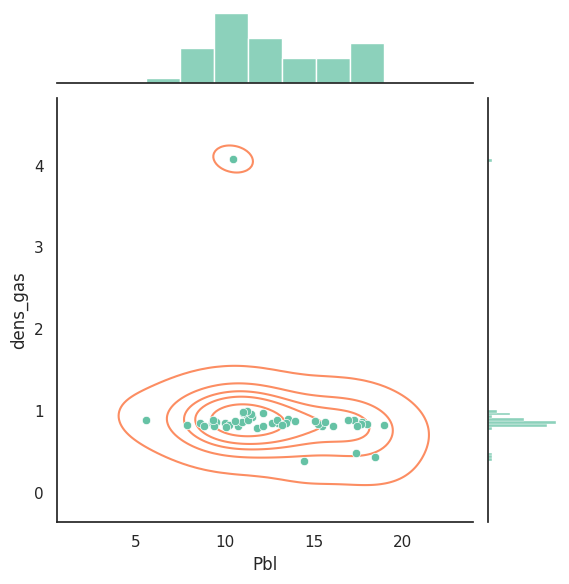

In [ ]:
# Jointplot with histograms, KDE, and scatter for 2 variables
def visualize_jointplot(df):
    sns.set(style="white", color_codes=True)
    g = sns.jointplot(x="Pbl", y="dens_gas", data=df, kind="scatter", color=sns.color_palette("Set2")[0])
    g.plot_joint(sns.kdeplot, color=sns.color_palette("Set2")[1], zorder=0, levels=6)
    plt.show()
visualize_jointplot(df)
# sns.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm", hue="species")

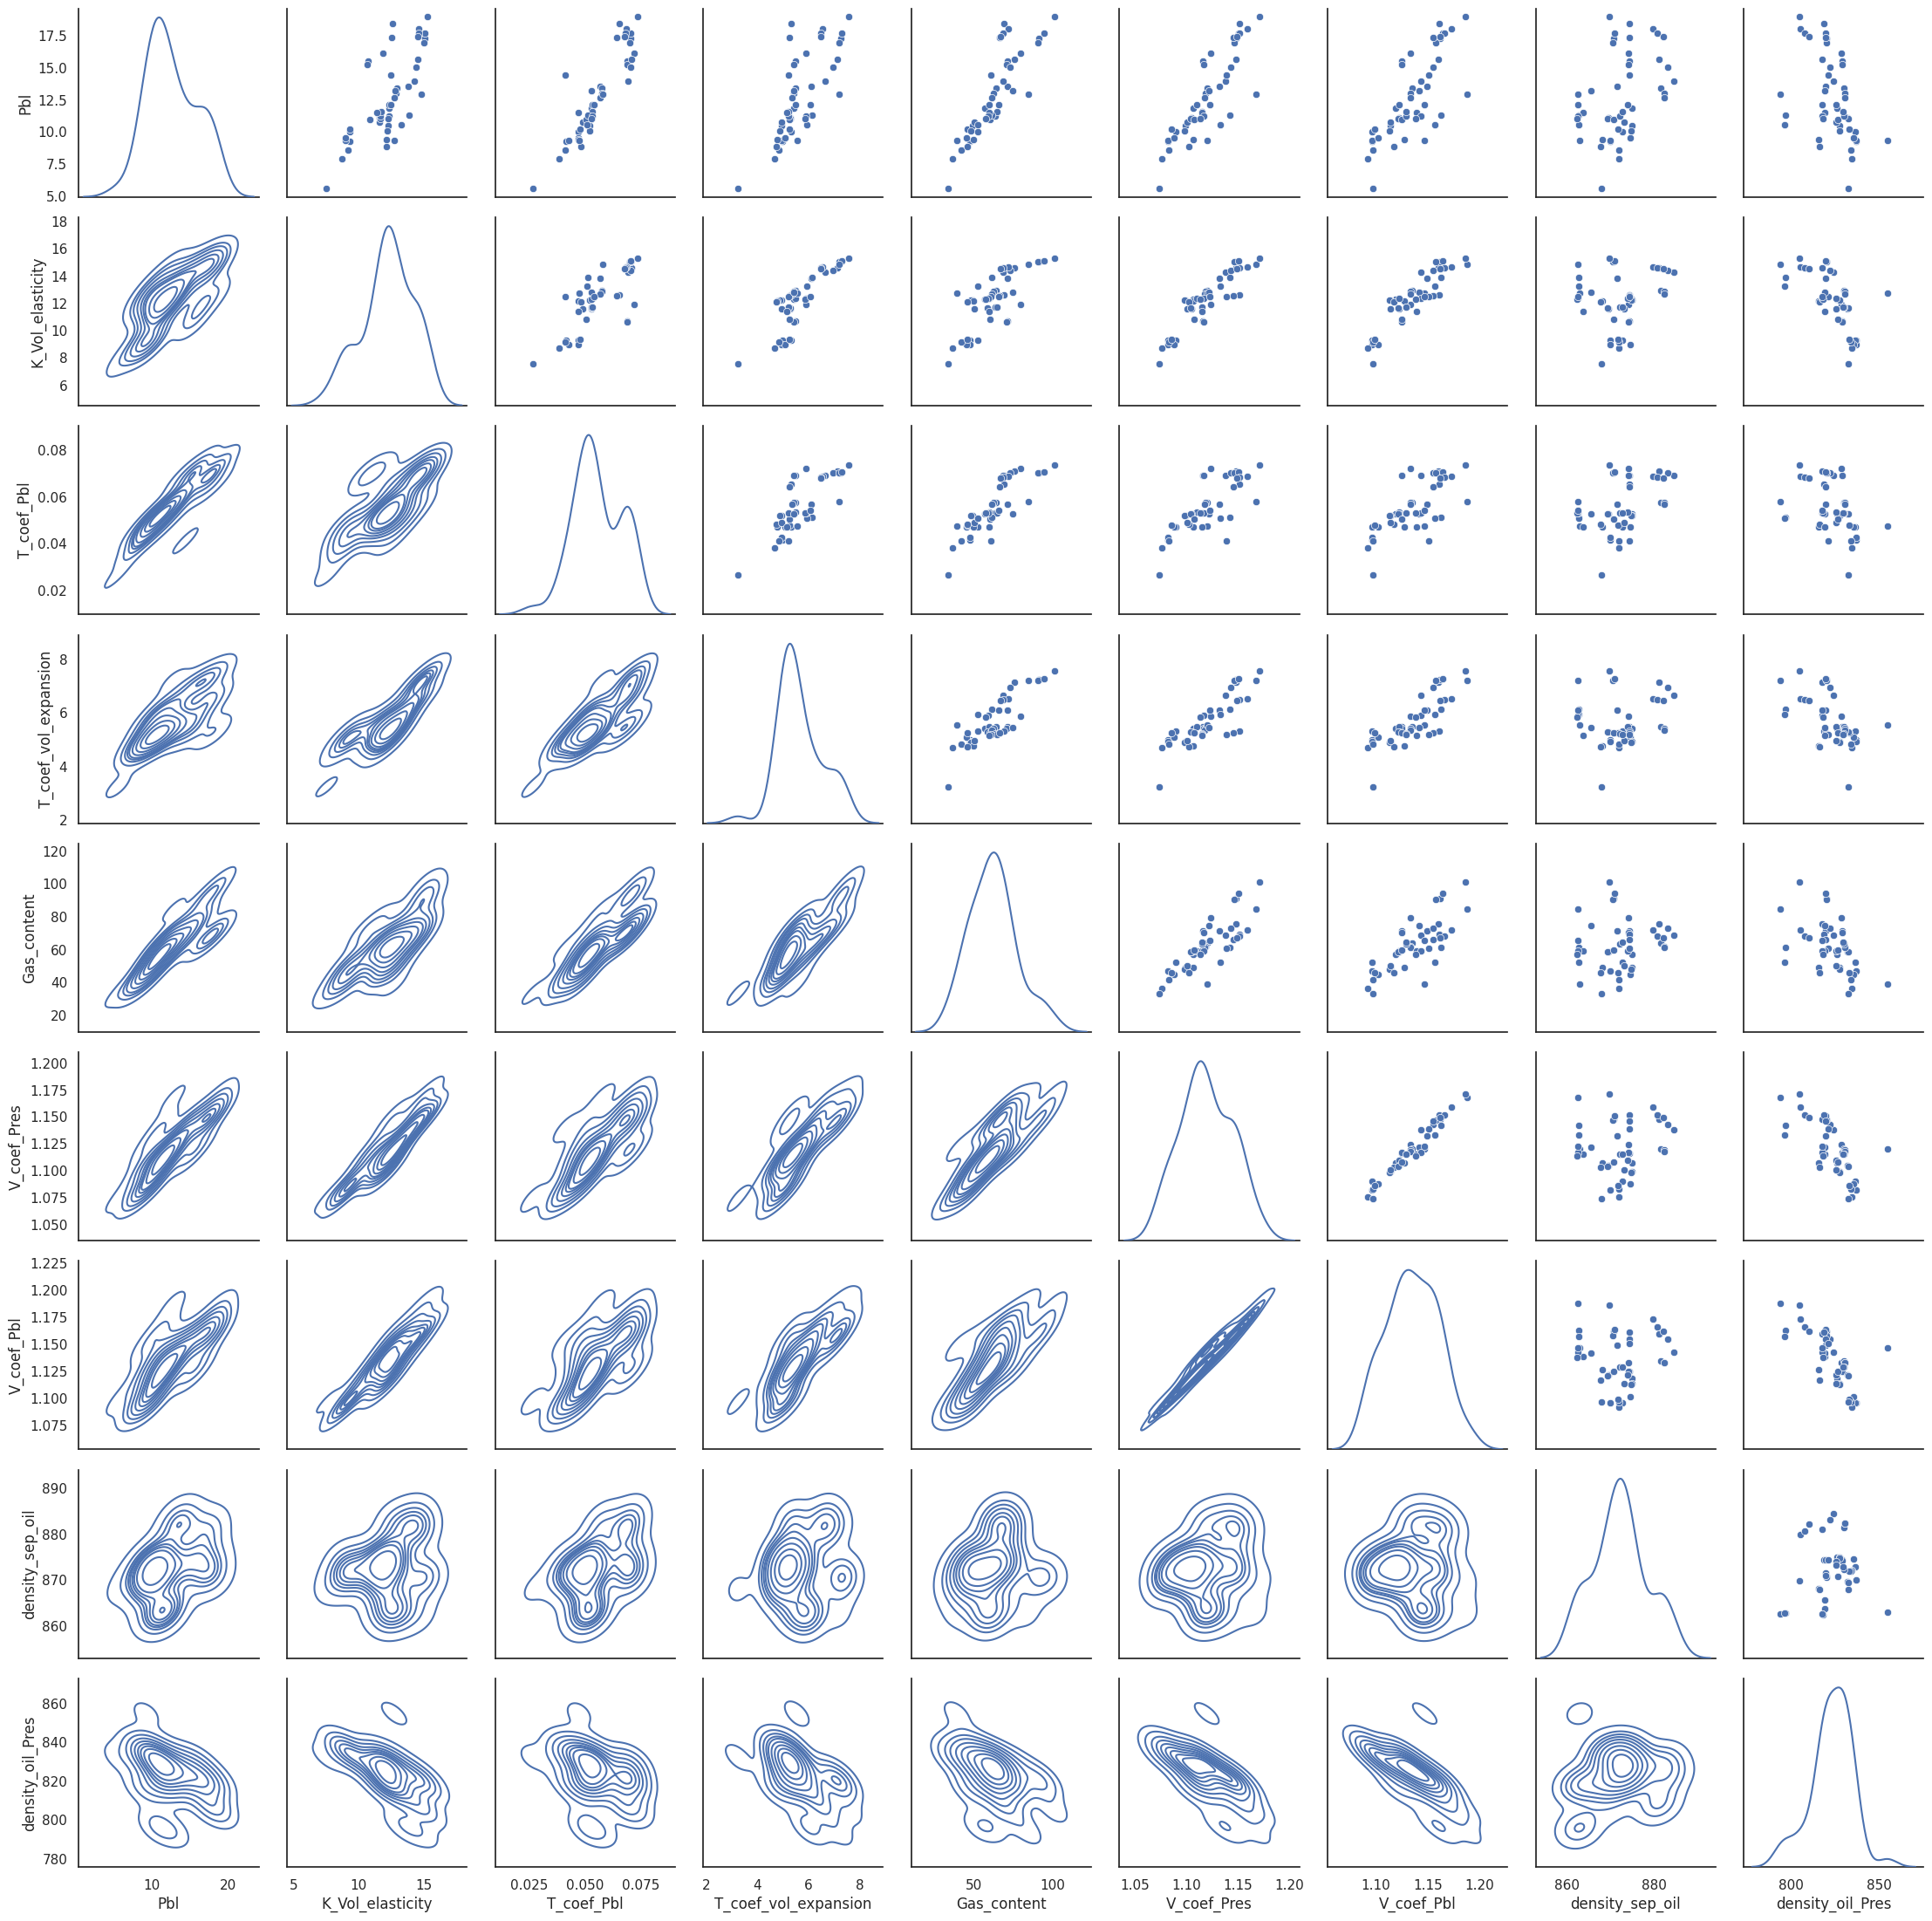

In [ ]:
g = sns.PairGrid(df_cl, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

In [ ]:
n_rows_old = df.shape[0]
# Step 1: Check for duplicates
df, duplicates = check_duplicates(df)

n_rows_new = df.shape[0]
print(f'{n_rows_old - n_rows_new} duplicates have been removed')

0 duplicates have been removed


In [ ]:
# Step 2: Filter observations
df, removed_df = filter_observations(df)

In [ ]:
removed_df

,Well,Int_perf,layer,date,depth,Pres,Temperature,Pbl,K_Vol_elasticity,T_сoef_Pbl,...,density_sep_oil,density_oil_Pres,density_oil_Pbl,visc_oil_Pres,visc_sep_oil_Tres,visc_sep_oil_20C,dens_gas,noncondition,ratio_density_stand-step,Unnamed: 23
3,1PO,2263-2285,AC9,2018-03-18 00:00:00,2220,23.00,78.0,16.11,11.88,0.0719,...,874.2,828.3,821.4,1.330,4.380,22.63,0.817,1,1.002408,NaN
4,1PO,2263-2285,AC9,2018-03-18 00:00:00,2220,23.00,78.0,15.48,10.70,0.0690,...,874.3,828.8,822.1,1.390,4.510,22.67,0.812,1,NaN,NaN
5,1PO,2263-2285,AC9,2018-03-18 00:00:00,2220,23.00,78.0,15.24,10.65,0.0690,...,874.1,829.1,823.1,1.420,4.720,22.74,0.843,1,NaN,NaN
7,3PO,2299-2318,AC9,2018-10-09 00:00:00,2299-2318,23.00,74.0,7.87,8.72,0.0383,...,872.0,834.6,822.8,NaN,NaN,17.95,0.823,1,1.003221,NaN
8,3PO,2299-2318,AC9,2018-10-09 00:00:00,2299-2318,23.00,74.0,8.60,9.18,0.0410,...,871.9,833.9,823.1,NaN,NaN,17.97,0.857,1,1.002876,NaN
9,3PO,2299-2318,AC9,2018-10-09 00:00:00,2299-2318,23.00,74.0,10.23,9.32,0.0477,...,871.8,833.1,823.2,NaN,NaN,18.21,0.826,1,1.002645,NaN
11,1016R,2545-2561,AC9,2019-08-08 00:00:00,NaN,24.02,72.3,10.47,12.23,0.0521,...,875.0,827.5,816.8,NaN,4.410,18.27,4.080,0,1.013201,1.0
13,1032R,2388-2428,AC9,2019-08-16 00:00:00,NaN,20.58,59.0,9.39,12.16,0.0470,...,868.1,815.7,805.7,NaN,5.259,15.27,0.822,1,1.010241,NaN
14,1032R,2388-2428,AC9,2019-08-16 00:00:00,NaN,20.58,59.0,8.82,12.10,0.0482,...,867.8,816.3,806.0,NaN,5.179,14.92,0.818,1,1.010362,NaN
19,2PO,2529-2560,AC10,2018-11-22 00:00:00,NaN,25.00,79.0,5.59,7.52,0.0266,...,867.9,832.2,814.8,NaN,3.210,15.26,0.895,1,1.003701,NaN


In [ ]:
df.shape

(36, 24)

In [ ]:
n_rows_old = df.shape[0]
# Step 3: Remove outliers by temperature
df, outliers = remove_temperature_outliers(df)

n_rows_new = df.shape[0]
print(f'{n_rows_old - n_rows_new} outliers have been removed')

1 outliers have been removed


In [ ]:
outliers

,Well,Int_perf,layer,date,depth,Pres,Temperature,Pbl,K_Vol_elasticity,T_сoef_Pbl,...,density_sep_oil,density_oil_Pres,density_oil_Pbl,visc_oil_Pres,visc_sep_oil_Tres,visc_sep_oil_20C,dens_gas,noncondition,ratio_density_stand-step,Unnamed: 23
26,2PO,"2596,2_MDT",AC11,2018-06-15 00:00:00,2556.1,24.88,12.22,11.54,11.72,0.0532,...,872.8,829.4,818.6,3.75,4.306,17.64,0.922,0,1.003911,NaN


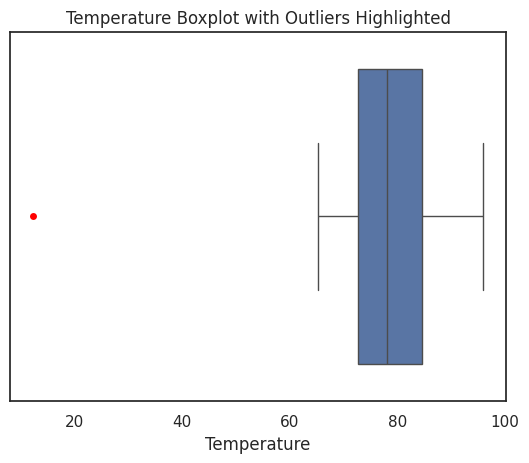

In [ ]:
# Step 8: Visualization of temperature outliers
visualize_temperature_outliers(df, outliers)


In [ ]:
# choose only 9 columns
df_full = df.copy()
df = df.iloc[:, 7:16]

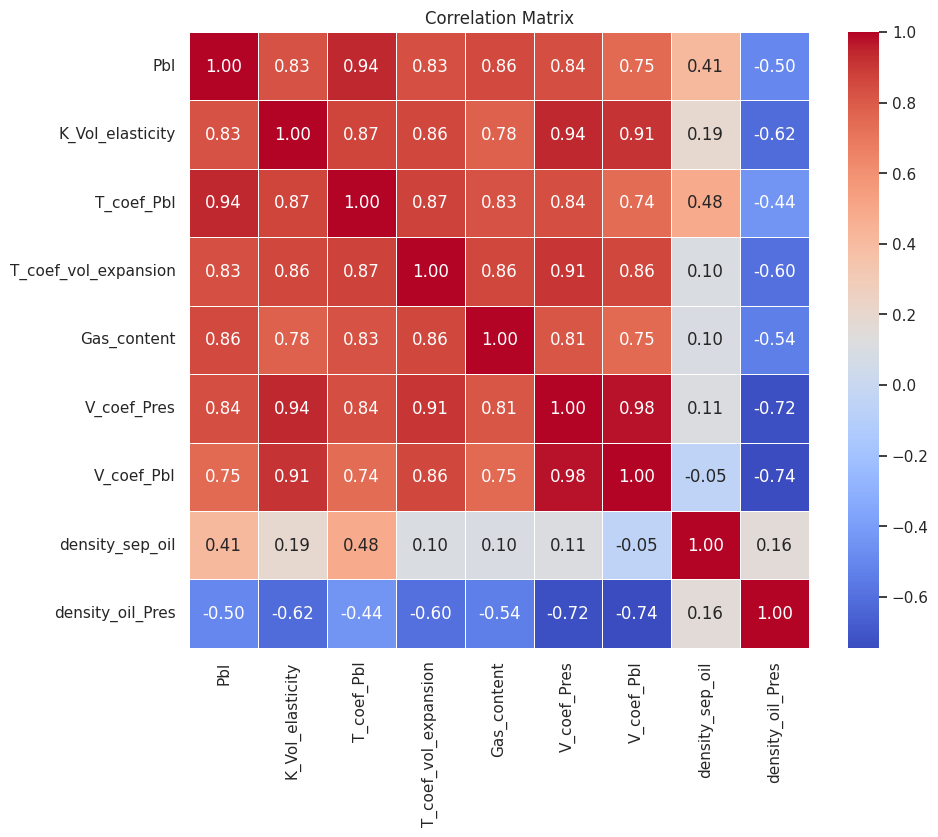

In [ ]:
# Correlation matrix
correlation_matrix = df.corr()

# Heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Step 4: PCA
pca_df = apply_pca2(df)

NameError: name 'PCA' is not defined

In [ ]:
# Step 5: Visualization of PCA
visualize_pca(pca_df)

In [ ]:
visualize_pca_3d(pca_df)


In [ ]:
pca_df.head()

In [ ]:
pca_df.shape

In [ ]:
# Step 6: Clustering
cluster_counts = clustering_pca(pca_df)

print("Number of records in each cluster:")
print(cluster_counts)

In [ ]:
pca_df.head()

In [ ]:
df_upd = pd.concat([df_full['layer'], pca_df['cluster'], df], axis = 1)
df_upd.head()

In [ ]:
# Step 7: Visualization of clustering decomposed on before PCA variables
# visualize_clustering_decomposed(pca_df, df)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='Pbl', y='T_сoef_Pbl', hue='cluster', data=df_upd, palette='viridis', ax=axs[0])
axs[0].set_title('Clustering on Original Variables')
axs[0].set_xlabel('Pbl')
axs[0].set_ylabel('T_сoef_Pbl')

sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', ax=axs[1]) #
axs[1].set_title('Clustering on PCA Components')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')

plt.show()
sns.jointplot(x='Pbl', y='K_Vol_elasticity', hue='cluster', data=df_upd, palette='viridis')


In [ ]:

g = sns.PairGrid(df_upd, diag_sharey=False,  hue='cluster', palette='viridis')
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)
g.add_legend()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Clustering
def clustering(df):
    attributes = df.iloc[:, 7:16] # Assuming columns Ppl to the end are the attributes
    scaler = StandardScaler()
    scaled_attributes = scaler.fit_transform(attributes)

    kmeans = KMeans(n_clusters=3, random_state=0)
    df['cluster'] = kmeans.fit_predict(scaled_attributes)

    cluster_counts = df['cluster'].value_counts()
    plast_counts = df.groupby('cluster')['layer'].nunique()

    return cluster_counts, plast_counts

      # # Example usage
      # # Load your dataset into a DataFrame named df
      # # df = pd.read_csv('your_dataset.csv')

      # # Step 1: Check for duplicates
      # df = check_duplicates(df)

      # # Step 2: Filter observations
      # df = filter_observations(df)

      # # Step 3: Remove outliers by temperature
      # df = remove_temperature_outliers(df)

# Step 4: Clustering
cluster_counts, plast_counts = clustering(df_full)

print("Number of records in each cluster:")
print(cluster_counts)
print("\nNumber of plasts in each cluster:")
print(plast_counts)


Number of records in each cluster:
cluster
1    16
2    11
0     8
Name: count, dtype: int64

Number of plasts in each cluster:
cluster
0    4
1    3
2    3
Name: layer, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



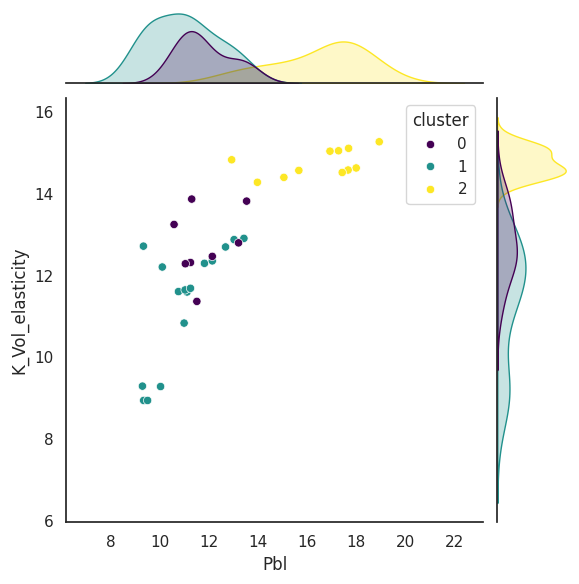

In [ ]:

sns.jointplot(x='Pbl', y='K_Vol_elasticity', hue='cluster', data=df_full, palette='viridis')

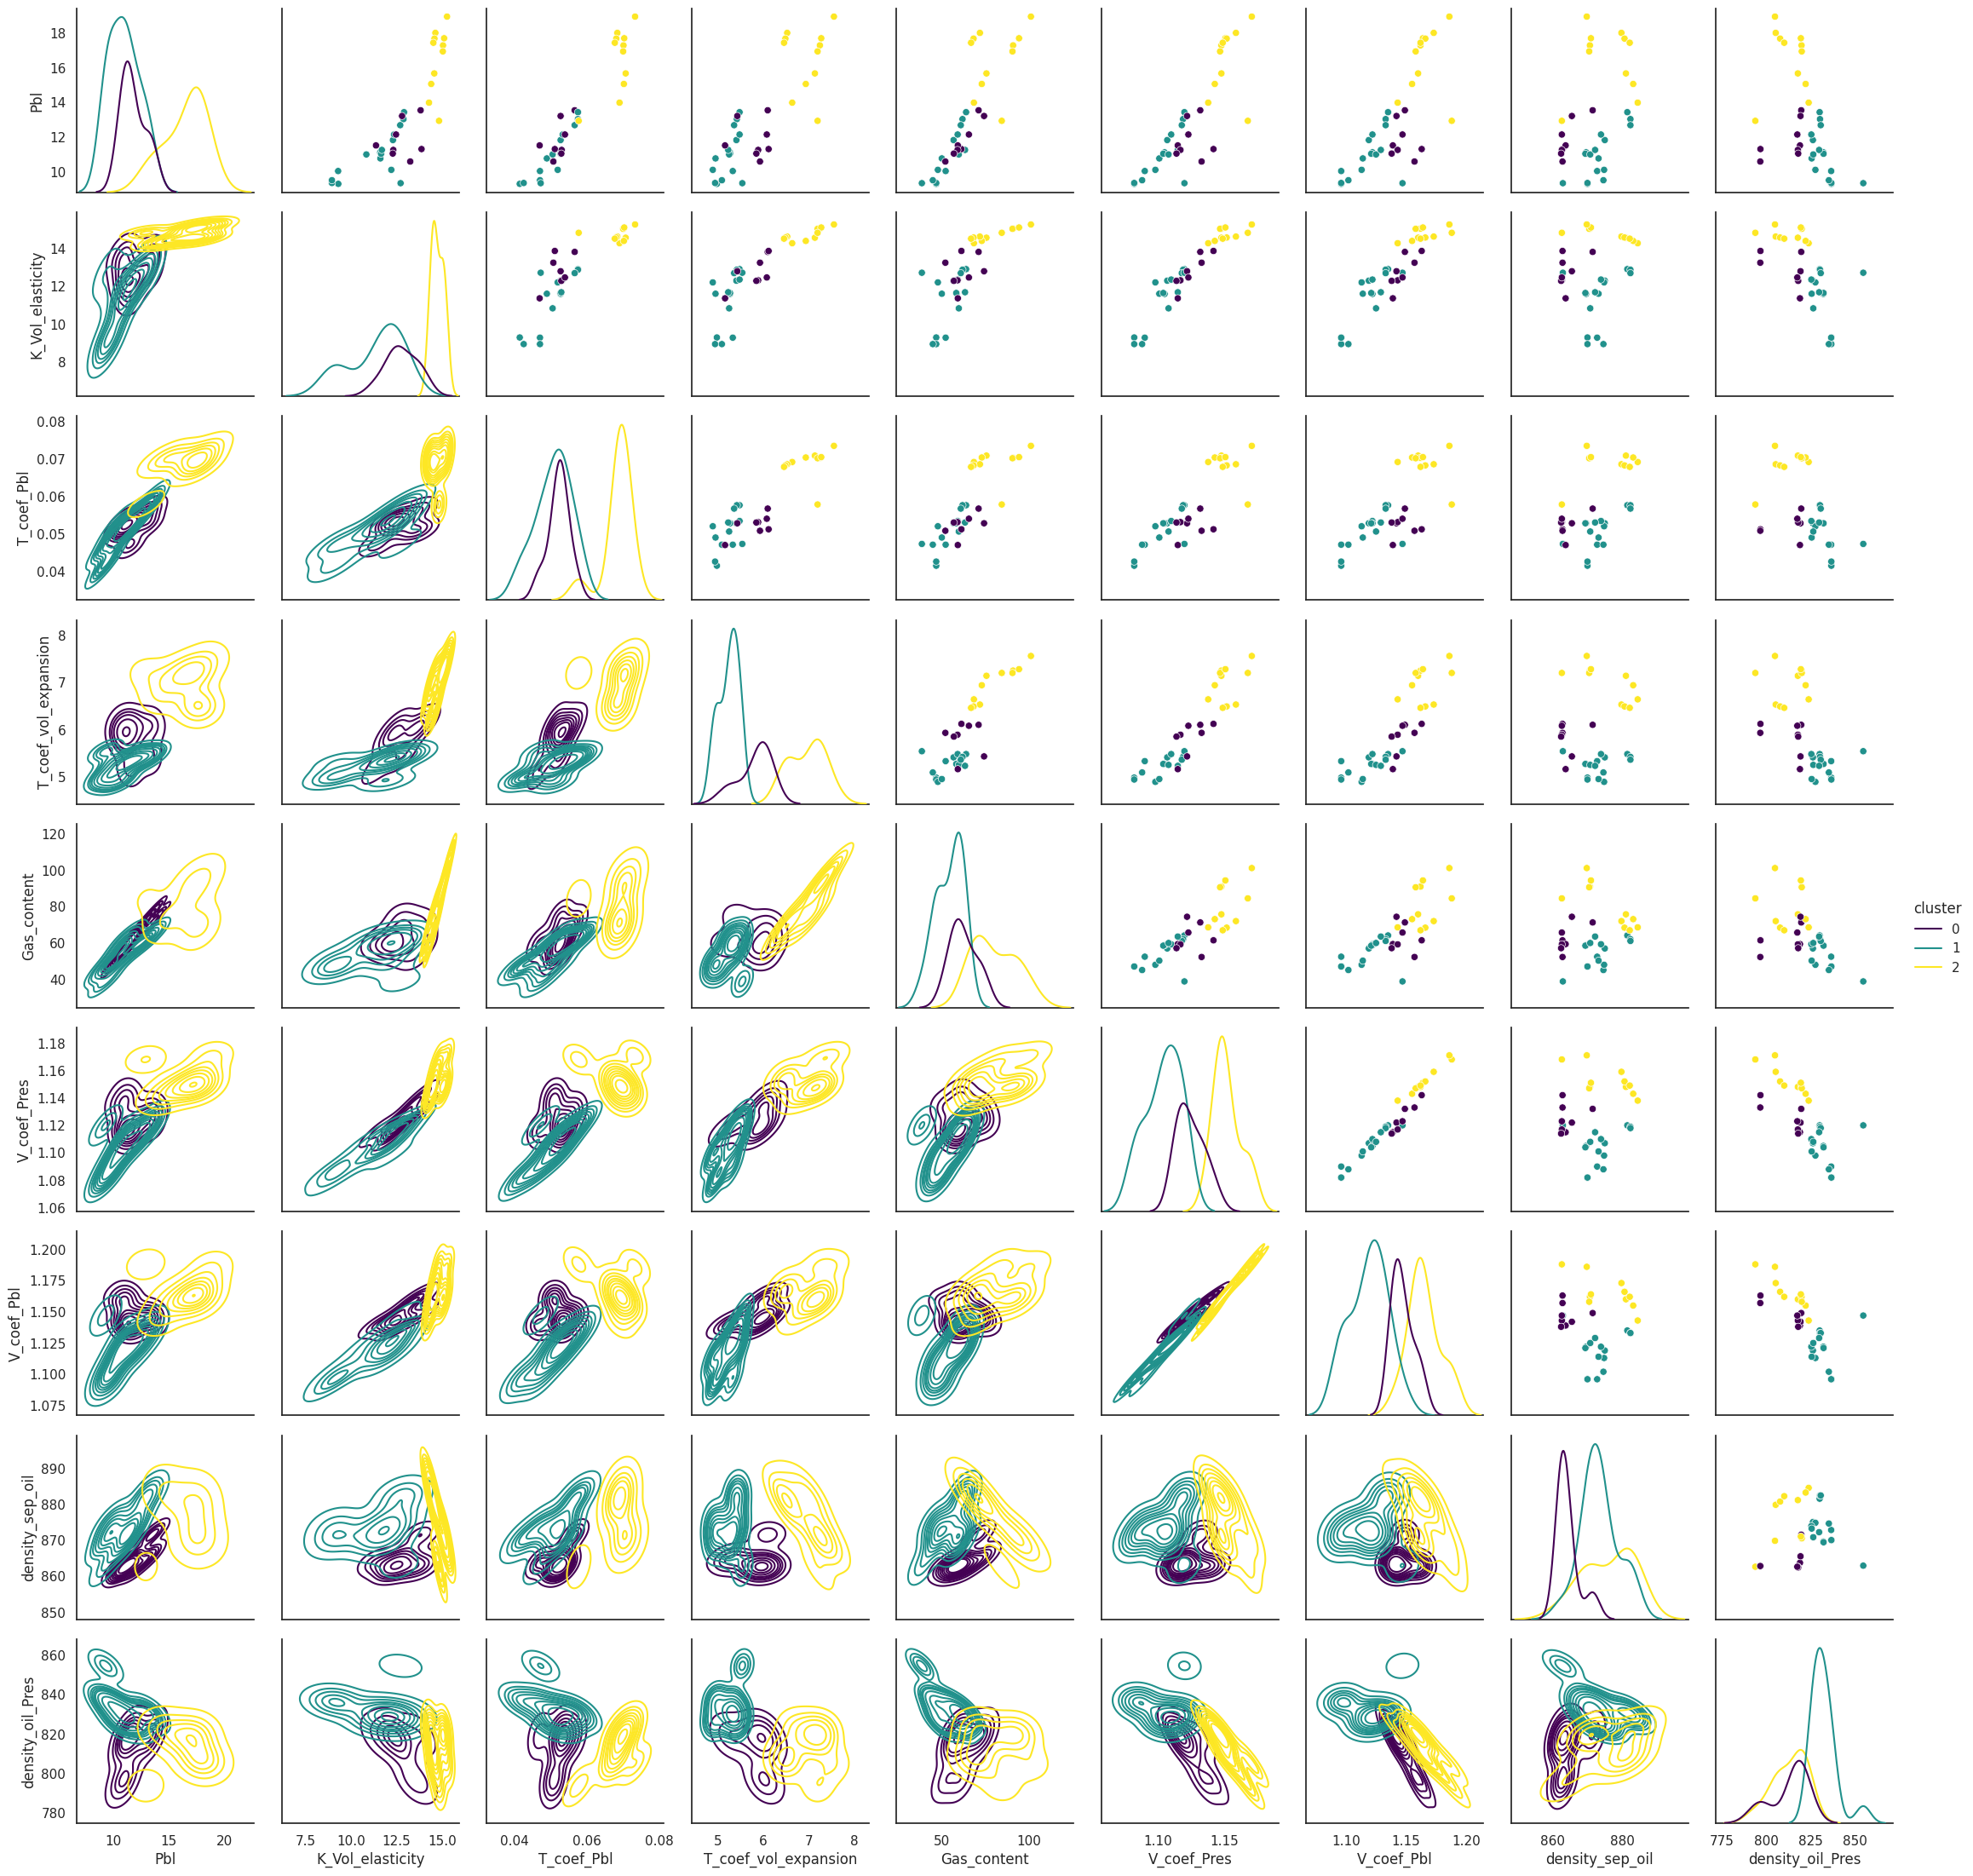

In [ ]:
usecols = ['Pbl', 'K_Vol_elasticity', 'T_сoef_Pbl', 'T_coef_vol_expansion',
       'Gas_content', 'V_coef_Pres', 'V_coef_Pbl', 'density_sep_oil',
       'density_oil_Pres', 'cluster']

b = sns.PairGrid(df_full[usecols], diag_sharey=False,  hue='cluster', palette='viridis')
b.map_upper(sns.scatterplot)
b.map_lower(sns.kdeplot)
b.map_diag(sns.kdeplot)
b.add_legend()

In [ ]:
cluster_counts.index.tolist()

[1, 2, 0]